# COVID19 Dataset Processing
This notebooks covers the basic preprocessing done to the COVID 19 dataset

In [1]:
# https://www.tensorflow.org/tutorials/distribute/keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import load_model

import tensorflow as tf
import efficientnet.tfkeras as ef

import os
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] = "5"
import ast

import pydicom

import pandas as pd

In [2]:
import ast
import imageio
import matplotlib.pyplot as plt
import os
import numpy as np
from skimage.transform import resize
import h5py
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import sys
from padchest_handler import PadChestDataHandler

import glob
import SimpleITK as sitk
from skimage.transform import resize
import json
import h5py



In [3]:
padchest_path = '/mnt/data/dbext/padchest/'
covid19_path = '/mnt/data/dbext/covid19/images/'
output_dir = '/mnt/ssd/tmp/BIMCV_COVID19+'


# If you run the notebook the first time you may want to generate the h5 and the first pandas df with all the DICOM information
generate_h5_and_pandas = True

pa_ll_model_file = 'Frontal_Lateral_Model.h5'

# Paths needed to train the frontal / lateral model in case the model does not exist
padchest_imgs_dir = os.path.join(padchest_path, 'images_1024/') # I have all images there at 1024 px resolution
padchest_reference_standard = os.path.join(padchest_path, 'reference/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv')
tmp_padchest_h5 = os.path.join(output_dir, 'padchest_pa_L_299.hdf5')

# Paths to the dataset
covid19_labels_nlp = os.path.join(covid19_path, 'derivatives/labels/labels_covid19_posi.tsv')
tests_file = os.path.join(covid19_path, 'derivatives/EHR/sil_reg_covid.tsv')

# Output files - several csvs and a h5 with the image data
covid19_pandas = os.path.join(output_dir, 'covid19_20200527.csv')
covid19_h5 = os.path.join(output_dir, 'covid19_20200527.hdf5')
covid19_merged_file = os.path.join(output_dir, 'covid19_20200527_with_test_date.csv')
merged_file_qc = os.path.join(output_dir, 'covid19_20200527_with_test_date_qc.csv')
merged_file_qc_reports = os.path.join(output_dir, 'covid19_20200527_with_test_date_qc_with_reports.csv')


# Step 1 - Create a discriminator between frontal and lateral images

In [5]:
# Two epochs are enough for the training - this has been determined experimentally. 
# After two epochs the model tends to overfit

if not os.path.exists(pa_ll_model_file):
    
    tmp_padchest_file = tmp_padchest_h5
    
    n_samples = 1000
    imgs_dir = padchest_imgs_dir
    dt = pd.read_csv(padchest_reference_standard)
    dt['Projection'].value_counts()
    
    inputs = Input((299, 299, 3))
    base_model = ef.EfficientNetB4(include_top=False, weights="imagenet", pooling='avg')(inputs)
    do = Dropout(rate=0.2)(base_model)
    predictions = Dense(1, activation="sigmoid", name="predictions")(do)
    model = Model(inputs=inputs, outputs=predictions)
    optimizer = Adam(lr=1e-4)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])

    # Generates an H5 with all the image files - this is optional, but useful
    if not os.path.exists(tmp_padchest_file):
        error_idxs = []
        errors = []
        dt_pa = dt[dt['Projection']=='PA']
        dt_l = dt[dt['Projection']=='L']
        rs_pa = dt_pa[0:n_samples].append(dt_l[0:n_samples])
        
        f = h5py.File(tmp_padchest_h5, 'w')
        f.create_dataset("images", (len(rs_pa), 299, 299), chunks=(1, 299, 299), dtype=np.uint16)
        for i in range(0, len(rs_pa)):
    #     for i in range(0, 20):
            error = 0
            if i % 500 == 0:
                print(i, len(rs_pa), len(error_idxs))
            try:
                img = imageio.imread(os.path.join(imgs_dir, rs_pa.iloc[i]['ImageID']))
            except:
                try:
                    im_frame = Image.open(os.path.join(imgs_dir, rs_pa.iloc[i]['ImageID']))
                    img =  np.array(im_frame.getdata()).reshape(im_frame.size[0], im_frame.size[1])
                except:
                    error_idxs.append(i)
                    img = np.zeros((299,299))
                    error = 1
            errors.append(error)
            imgl = min(img.shape[0], img.shape[1])
            imgl = int((imgl - imgl%2)/2)
            imgc = img[ int(img.shape[0]/2 - imgl):int(img.shape[0]/2 + imgl),
                        int(img.shape[1]/2 - imgl):int(img.shape[1]/2 + imgl)]
            imgr =resize(imgc, (299,299), anti_aliasing=True, preserve_range=True).astype(np.uint16)        
            f["images"][i,:,:] = imgr[:,:]
        f.close()

    
    f2 = h5py.File(tmp_padchest_file, 'r')
    plt.imshow(f2['images'][n_samples-1,:,:], cmap='gray')    
    f2.close()
    
    idxs = np.arange(0,n_samples*2)
    np.random.shuffle(idxs)
    xt = np.zeros((n_samples, 299, 299, 3))
    yt = np.zeros((n_samples, 1))
    xv = np.zeros(( int(n_samples/2), 299, 299, 3))
    yv = np.zeros(( int(n_samples/2), 1))
    xtt = np.zeros(( int(n_samples/2), 299, 299, 3))
    ytt = np.zeros((int(n_samples/2), 1))

    f2 = h5py.File(tmp_padchest_h5, 'r')
    for i in range(0, n_samples):
        im = f2['images'][idxs[i]]
        imr = (im - np.mean(im))/np.std(im)
        for k in range(0,3):
            xt[i,:,:,k] = imr
        yt[i] = (idxs[i]<n_samples)*1.0

    for i in range(n_samples, int(n_samples*3/2)):
        im = f2['images'][idxs[i]]
        imr = (im - np.mean(im))/np.std(im)
        for k in range(0,3):
            xv[i-n_samples,:,:,k] = imr
        yv[i-n_samples] = (idxs[i]<n_samples)*1.0

    for i in range(int(n_samples*3/2), n_samples*2):
        im = f2['images'][idxs[i]]
        imr = (im - np.mean(im))/np.std(im)

        for k in range(0,3):
            xtt[i-int(n_samples*3/2),:,:,k] = imr
        ytt[i-int(n_samples*3/2)] = (idxs[i]<n_samples)*1.0
    f2.close()    

    model.fit(xt, yt, validation_data=(xv,yv), epochs=2)
    model.save(pa_ll_model_file)
    
    y_pred = model.predict(xtt, verbose=True)
    from sklearn.metrics import accuracy_score
    accuracy_score(ytt, y_pred > 0.5)

else:
    model = load_model(pa_ll_model_file)

# Step 2 - Generate the dataset
Look at all DX and CR images of the dataset, compute their projection, generate a large csv with all the DICOM fields. Merge with the test data (the closest in time)

In [6]:
r_dir = covid19_path
paths = glob.glob(r_dir + "/*/*/*/*.png")
paths_ct  = glob.glob(r_dir + "/*/*/*/*.nii.gz")

In [7]:
pandas_file = covid19_pandas
h5_file = covid19_h5


def json_to_dict(p):
    dti = dict()
    path = p.replace(r_dir, "").split("/")
    modality = path[-1].replace(".png", "").split("_")[-1]    
    dti['Subject'] = path[0]
    dti['Session'] = path[1]
    dti['mod'] = path[2]
    dti['File'] = path[3]
    dti['Type'] = modality
    dti['Path'] = p
    json_file = p.replace('.png', '.json').replace('.nii.gz', '.json')
    # If there is no json associated with the file, then pick the json on the series. 
    # Maybe multiple acquisitions with the same parameters in the same series?
    if not os.path.exists(json_file):
        json_in_series = glob.glob(os.path.join(r_dir, path[0], path[1], path[2], '*.json'))
        if len(json_in_series) >= 1:
            json_file = json_in_series[0]
    if os.path.exists(json_file):
        with open(json_file) as f:
            dtij = json.load(f)
        for l in dtij.keys():
            if 'Value' in dtij[l].keys():
                try:
                    dti[pydicom.datadict.dictionary_description(str(l))] = dtij[l]['Value']
                except:
                    dti[str(l)] = dtij[l]['Value']
    else:
        print(p)
    return dti


if generate_h5_and_pandas:
    
    dtl = []
    
    print("Parsing the jsons of the cts")
    for iddd, p in enumerate(paths_ct):
        if iddd % 250 == 0:
            print(iddd, len(paths_ct))
        dti = json_to_dict(p)
        dtl.append(dti)      
    
    
    fh5 = h5py.File(h5_file, 'w')
    fh5.create_dataset("images", (len(paths), 299, 299), chunks=(1, 299, 299), dtype=np.uint16)

    print("Parsing the jsons of the chest images and creating the h5 - this takes a while ...")
    for iddd, p in enumerate(paths):
        if iddd % 250 == 0:
            print(iddd, len(paths))
        dti = json_to_dict(p)
            
        if dti['Modality'][0] == 'DX' or dti['Modality'][0] == 'CR':
            sitk_img = sitk.ReadImage(p)
            img = sitk.GetArrayFromImage(sitk_img)
            if dti['Photometric Interpretation'][0] == "MONOCHROME1":
                img = -img
            imgl = min(img.shape[0], img.shape[1])
            imgl = int((imgl - imgl%2)/2)
            imgc = img[ int(img.shape[0]/2 - imgl):int(img.shape[0]/2 + imgl),
                        int(img.shape[1]/2 - imgl):int(img.shape[1]/2 + imgl)]
            imgc = 1.0*(imgc - np.min(np.ravel(imgc))) / (np.max(np.ravel(imgc)) - np.min(np.ravel(imgc)) )
            imgr = resize(imgc, (299,299), anti_aliasing=True, preserve_range=True)
            fh5["images"][iddd,:,:] = (( (imgr[:,:] - np.min(np.ravel(imgr))) / (np.max(np.ravel(imgr)) - np.min(np.ravel(imgr)) ))*(2**16-1)).astype(np.uint16)

            imgp = np.zeros((1,299,299,3))
            for k in range(0,3):
                imgp[0,:,:,k] = imgr
            score = model.predict(imgp)[0][0]
            dti['Position_DL_Score'] = score
            if score > 0.5:
                dti['Position_DL'] = 'PA'
            else:
                dti['Position_DL'] = 'L'
        else:
            dti['Position_DL'] = 'CT-N/A'
            dti['Position_DL_Score'] = 0
        dti['h5_idx'] = iddd
        dtl.append(dti)
    fh5.close()
        
        
    dt = pd.DataFrame.from_dict(dtl)    
    dt.to_csv(pandas_file, index=False)
    dt = pd.read_csv(pandas_file, low_memory=False)    
    
else:
    dt = pd.read_csv(pandas_file, low_memory=False)
    
    

    
    

0 2291
250 2291
500 2291
750 2291
1000 2291
1250 2291
1500 2291
1750 2291
2000 2291
2250 2291
0 3296
250 3296
500 3296
750 3296
1000 3296
1250 3296
1500 3296
1750 3296
2000 3296
2250 3296
2500 3296
2750 3296
3000 3296
3250 3296


In [8]:
# Merge with test data

merged_file = covid19_merged_file

tests = pd.read_csv(tests_file, sep='\t')
tests['fecha2'] = pd.to_datetime(tests['fecha'], format='%d.%m.%Y')
dt['Study Date2'] = pd.to_datetime([ast.literal_eval(x['Study Date'])[0] for i, x in dt.iterrows()], format='%Y%m%d')
aa = dt.merge(tests, how='outer', left_on='Subject', right_on='participant')
aa['DStudy_Test'] = abs(aa['fecha2'] - aa['Study Date2'])
bb = aa.sort_values(by='DStudy_Test')
merged = bb.drop_duplicates(subset='File', keep='first')
# Elimintaes the temproal columns
merged = merged.drop(['Study Date2', 'fecha2', 'Subject_y'], axis=1)
merged = merged.rename(columns={'Subject_x':'Subject'})


# Elliminate the subjects that are on the test list but are not on the image data (1 case)
merged = merged.drop(merged[merged['File'].isnull()].index)


merged.to_csv(merged_file, index=False)

merged = pd.read_csv(merged_file, low_memory=False)

In [9]:
print(len(list(set(merged['Subject']))))
print(len(list(set(merged['Session']))))

1351
2559


# Step 3 - Validate the model
Look at the images with PA on the dicom fields and test if they are truly PA

In [10]:
img_data = h5py.File(h5_file, 'r')['images']

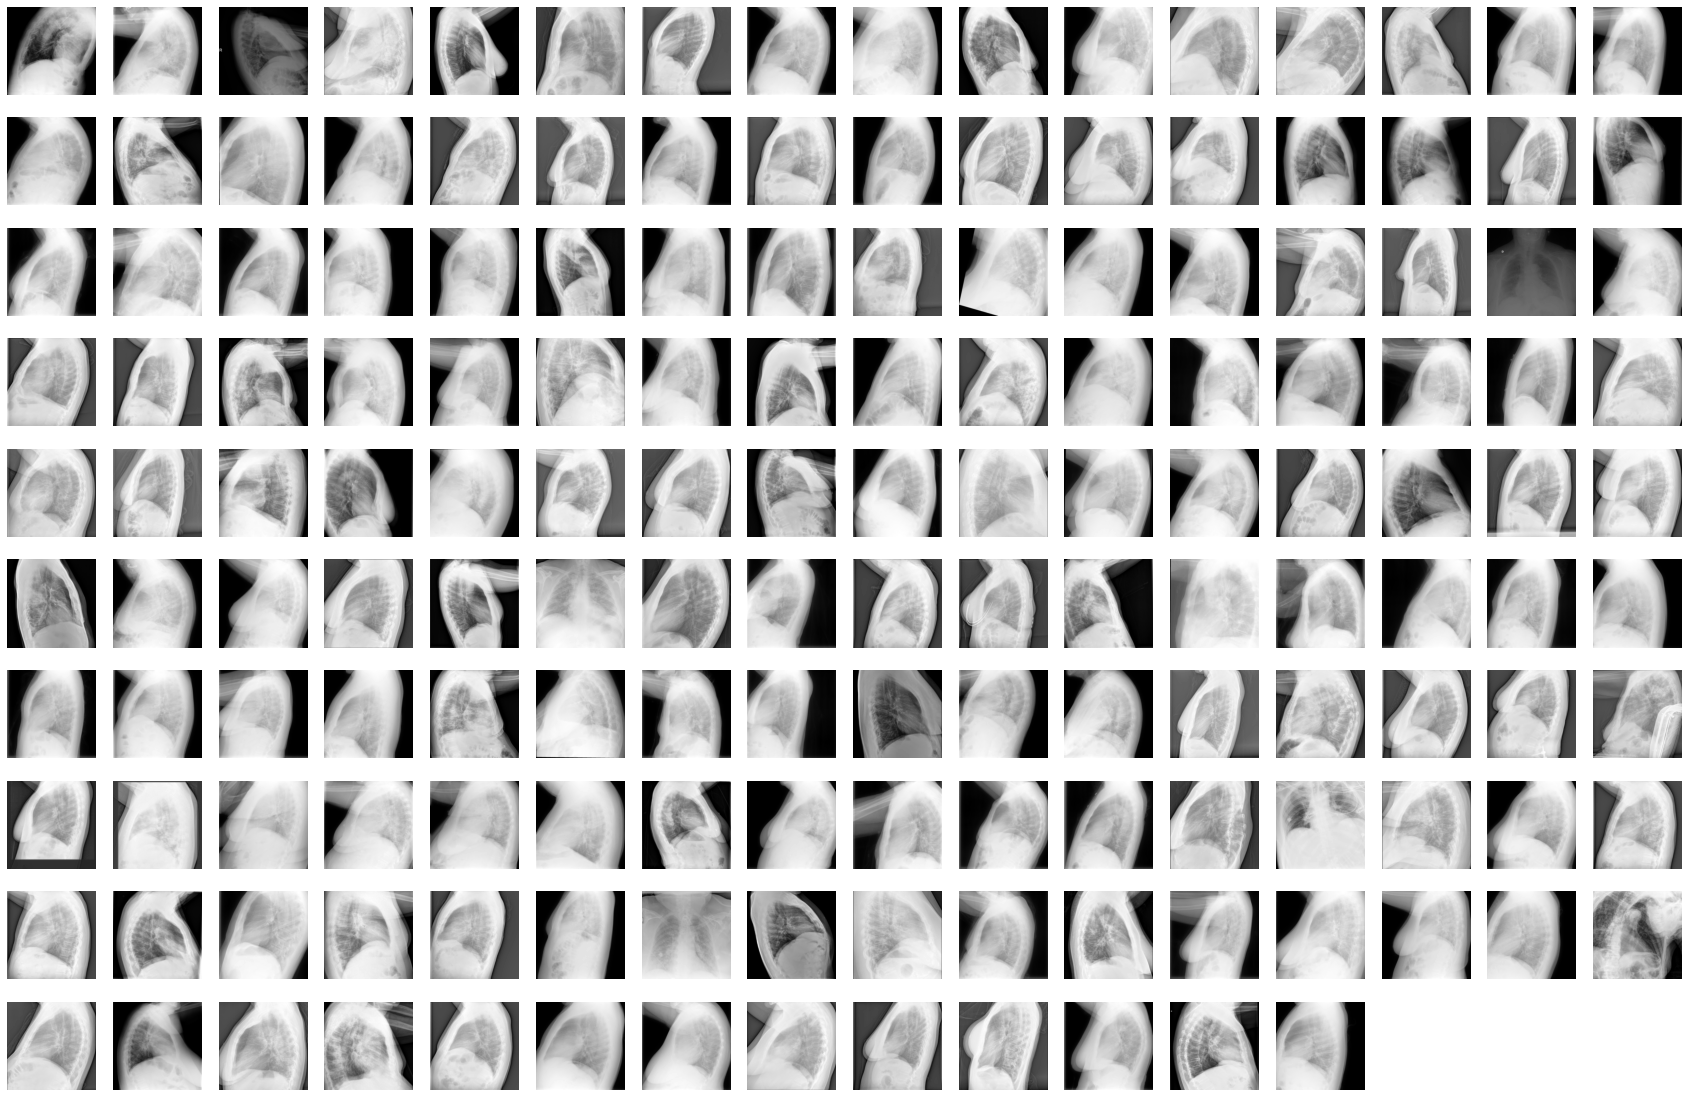

In [11]:
# Images tagged as PA or P on the dicom field 'View Position', but tagged as L using the deep learning method
# They are indeed lateral
discs_pa = dt[ (dt['Position_DL'] == 'L') & ((dt['View Position'] == "['PA']")  | (dt['View Position'] == "['AP']"))  ]
len(discs_pa)
plt.figure(figsize=(30,20))
for i in range(0,len(discs_pa)):
    kk= discs_pa.iloc[i]['h5_idx']
    plt.subplot(10,16,i+1)
    plt.imshow(img_data[kk], cmap='gray')
    plt.axis('off')

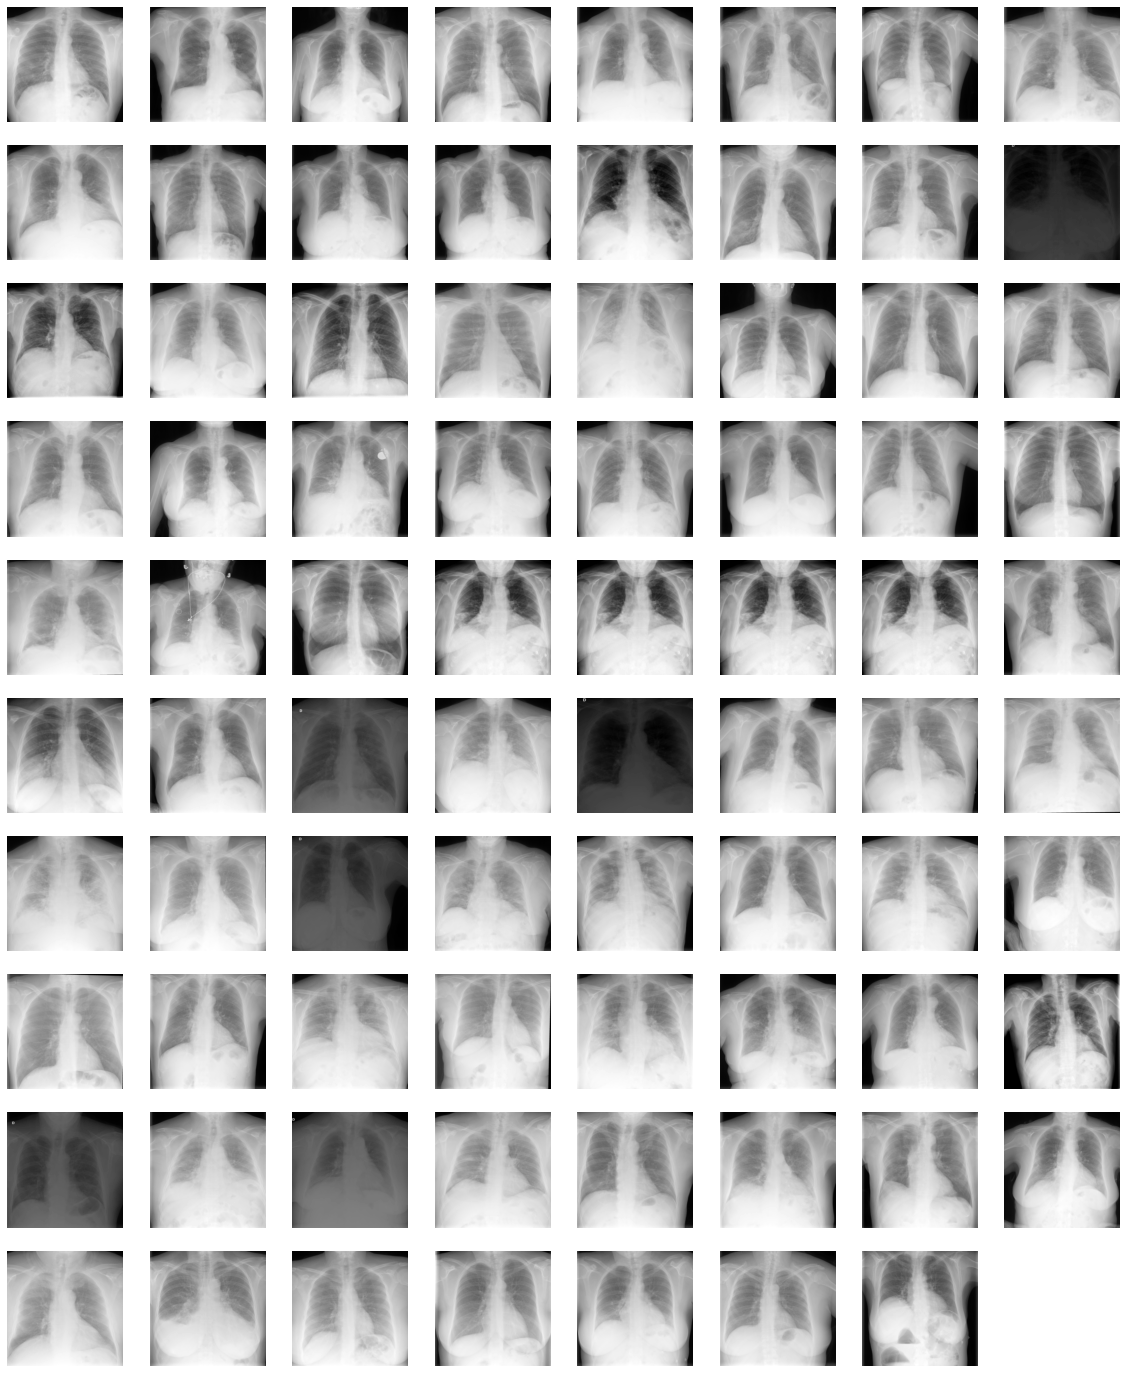

In [12]:
# Images tagged as Lateral on the dicom field 'View Position', but tagged as PA using the deep learning method
# They are indeed PA, except a very noisy one thet should be excluded 
discs_l = merged[ (merged['Position_DL'] == 'PA') & ((merged['View Position'] == "['LL']")  | (merged['View Position'] == "['LATERAL']") | (merged['View Position'] == 'LAT'))  ]
plt.figure(figsize=(20,25))
for i in range(0,len(discs_l)):
    kk= discs_l.iloc[i]['h5_idx']
    plt.subplot(10,8,i+1)
    plt.imshow(img_data[kk], cmap='gray')
    plt.axis('off')

In [13]:
# Save the pa projections for manual inspection using itk-snap
dt_pa = dt[dt['Position_DL'] == 'PA']

if False:
    imgs_pa = np.zeros((len(dt_pa), 299, 299), dtype=np.uint8)

    for i in range(0, len(dt_pa)):
        img = img_data[dt_pa.iloc[i]['h5_idx']]
        den = (np.max(np.ravel(img)) -  np.min(np.ravel(img)))
        if den == 0:
            den = 1
        img = ((img - np.min(np.ravel(img)))*255.0 / den).astype(np.uint8)
        imgs_pa[i] = img

    sitk.WriteImage(sitk.GetImageFromArray(imgs_pa), os.path.join(output_dir, 'covid19_pa_dl.nrrd') )


In [14]:
# Results of manual inspection - These index are painfully obtained by hand
p_burned_idx = [101,102,523,841,842, 2062, 2069, 2072,]
p_exclude = [469]
p_inverted = [801, 1869, 1920, 2137]
p_other = [125]

In [15]:
# Save the l projections for manual inspection using itk-snap
dt_l = dt[dt['Position_DL'] == 'L']

if False:
    imgs_l = np.zeros((len(dt_l), 299, 299), dtype=np.uint8)

    for i in range(0, len(dt_l)):
        img = img_data[dt_l.iloc[i]['h5_idx']]
        den = (np.max(np.ravel(img)) -  np.min(np.ravel(img)))
        if den == 0:
            den = 1
        img = ((img - np.min(np.ravel(img)))*255.0 / den).astype(np.uint8)
        imgs_l[i] = img

    sitk.WriteImage(sitk.GetImageFromArray(imgs_l), os.path.join(output_dir,'covid19_l_dl.nrrd'))    


In [16]:
# Results of manual inspection - These index are painfully obtained by hand

l_burned_idx = []
l_exclude = []
l_inverted = []
l_other = [4,11,30,32,65,67,68,69,70,76,79,94,111,118,187,192,196,201,208,210,249,257,300,
          301,302,306,328,329,330,331,333,335,336,337,353,360,363,366,373,374,375,376,419,
          420,436,437,438,439,440,441,442,452,453,455,456,528,541,553,554,555,582,583,585,
          586,588,592,594,598,599,606,615,624,639,662,683,703,704,705,706,707,709,711,712,
          714,719,720,722,726,727,737,759,768,769,786,800,807,816,820,822,823,824,825,826,
          827,828,841,855,865,867,888,893,921,922,923]

In [17]:
merged['Position_Manual'] = merged['Position_DL']
for dti, idxl in zip([dt_pa, dt_l], [p_other, l_other]):
    for idxi in idxl:
        row = dti.iloc[idxi]
        new_pos = 'PA'
        if row['Position_DL'] == 'PA':
            new_pos = 'L'
        merged.loc[merged['File'] == row['File'],'Position_Manual'] = new_pos

In [18]:
merged['Exclude'] = False
merged['Exclude Reason'] = ''

In [19]:
for dti, reasons, indexes_list in zip ( [dt_pa, dt_l], 
                                 [['burned in information', 'quality', 'inverted'], ['burned in information', 'quality', 'inverted']],
                                 [[p_burned_idx, p_exclude, p_inverted], [l_burned_idx, l_exclude, l_inverted]]):
    for reason, indexes in zip(reasons, indexes_list):
        for index in indexes:
            row = dti.iloc[index]            
            merged.loc[merged['File'] == row['File'],'Exclude'] = True
            merged.loc[merged['File'] == row['File'],'Exclude Reason'] = reason


In [20]:
merged.to_csv(merged_file_qc, index=False)

# Test to see the correlation between merged_file_qc and the h5


In [21]:
dtr = pd.read_csv(merged_file_qc, low_memory = False)
inverted = dtr[dtr['Exclude Reason'] == 'burned in information']


In [ ]:
for i, row in inverted.iterrows():
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(img_data[row['h5_idx']],cmap='gray')
    sitk_img = sitk.ReadImage(row['Path'])
    img = sitk.GetArrayFromImage(sitk_img)
    if row['Photometric Interpretation'] == "MONOCHROME1":
        img = -img
    plt.subplot(1,2,2)
    plt.imshow(img, cmap='gray')


# Step 4 - Merge with the information from the radiological reports

In [24]:
rs = pd.read_csv(covid19_labels_nlp, sep='\t')
dtr = pd.read_csv(merged_file_qc, low_memory = False)


In [25]:
dt_rs = dtr.merge(rs, how='outer', left_on=['Subject', 'Session'], right_on=['PatientID','ReportID'])

In [26]:
# There are several studies with images but without radiological reports. We remove them.
dt_rs = dt_rs.drop(dt_rs[dt_rs['PatientID'].isnull()].index)
dt_rs = dt_rs.drop(dt_rs[dt_rs['Subject'].isnull()].index)

In [27]:
dt_rs.to_csv(merged_file_qc_reports, index=False)
